In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import cv2
import pickle as pkl
import PIL
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation as R

In [513]:
from dreyevr_viz.lbc_data_utils import get_data
import sys
sys.path.append("/scratch/abhijatb/Bosch22")
from dreyevr_parser.parser import parse_file
from typing import Dict, List, Any
from utils import (
    check_for_periph_data,
    convert_to_df,
    split_along_subgroup,
    get_good_idxs,
)
from visualizer import plot_versus
from parser_utils import GetGazeDeviationFromHead
from ibmmpy.src.ibmmpy.ibmm import EyeClassifier

In [4]:
!ls /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/

exp_alex54   exp_dexter11  exp_esther32   exp_swapnil32  exp_tab54
exp_brady11  exp_dexter32  exp_esther54   exp_swapnil54
exp_brady32  exp_dexter54  exp_jacob54	  exp_tab11
exp_brady54  exp_esther11  exp_swapnil11  exp_tab32


In [5]:
from copy import deepcopy
import time

In [6]:
dataset_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/")
route_data_path = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_brady32")

In [8]:
!ls /scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_brady32_2022-08-09_14\:30\:24.274253

ls: cannot access '/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_brady32_2022-08-09_14:30:24.274253': No such file or directory


In [13]:
CARLA_ROOT = Path("/scratch/abhijatb/Bosch22/carla.harp_p13bd/")
sys.path.insert(0, str(CARLA_ROOT / 'PythonAPI/carla'))
sys.path.insert(0, str(CARLA_ROOT / 'PythonAPI/carla/dist/carla-0.9.13-py3.6-linux-x86_64.egg'))

import carla

In [10]:
import matplotlib as mpl ; mpl.use("Agg")
import matplotlib.animation as manimation
from matplotlib.pyplot import GridSpec

In [12]:
from PIL import Image, ImageDraw
def dot(img, x, y, color=(255, 255, 255), r=10):
    draw = ImageDraw.Draw(img)
    draw.ellipse((x-r, y-r, x+r, y+r), color)
dreyevr_recording_txt_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings/RecordingTxts/pre-newCA/")
movie_save_dir = "/scratch/abhijatb/Bosch22/dreyevr_recordings/"

## 3D to 2D conversion

# camera conversion

In [514]:
FOV = 90
w = 256
F = w / (2 * np.tan(FOV * np.pi / 360))

cam_info ={
    'F': F,
    'map_size' : 256,
    'pixels_per_world' : 5.5,
    'w' : 256,
    'h' : 144,
    'fy' : F,
    'fx' : 1.0 * F,
    'hack' : 0.4,
    'cam_height' : 1.3,
}

In [515]:
K = np.array([
[cam_info['fx'], 0, cam_info['w']/2],
[0, cam_info['fy'], cam_info['h']/2],
[0, 0, 1]])

def ptsWorld2Cam(focus_hitpt, world2camMatrix, K):
    
    tick_focus_hitpt_homog = np.hstack((focus_hitpt,1))    
    sensor_points = np.dot(world2camMatrix, tick_focus_hitpt_homog)

    # Now we must change from UE4's coordinate system to an "standard"
    # camera coordinate system (the same used by OpenCV):

    # ^ z                       . z
    # |                        /
    # |              to:      +-------> x
    # | . x                   |
    # |/                      |
    # +-------> y             v y

    # This can be achieved by multiplying by the following matrix:
    # [[ 0,  1,  0 ],
    #  [ 0,  0, -1 ],
    #  [ 1,  0,  0 ]]

    # Or, in this case, is the same as swapping:
    # (x, y ,z) -> (y, -z, x)
    point_in_camera_coords = np.array([
        sensor_points[1],
        sensor_points[2] * -1,
        sensor_points[0]])

    # Finally we can use our K matrix to do the actual 3D -> 2D.
    points_2d = np.dot(K, point_in_camera_coords)

    # Remember to normalize the x, y values by the 3rd value.
    # points_2d = np.array([
    #     points_2d[0, :] / points_2d[2, :],
    #     points_2d[1, :] / points_2d[2, :],
    #     points_2d[2, :]])
#     print(points_2d)
    points_2d /= points_2d[2]
#     print(points_2d)

    # At this point, points_2d[0, :] contains all the x and points_2d[1, :]
    # contains all the y values of our points. In order to properly
    # visualize everything on a screen, the points that are out of the screen
    # must be discarted, the same with points behind the camera projection plane.
    # points_2d = points_2d.T

    # Extract the screen coords (uv) as integers.
    u_coord = points_2d[0].astype(np.int)
    v_coord = points_2d[1].astype(np.int)
    
    return (u_coord, v_coord)

In [516]:
def world2pixels(focus_hitpt, vehicle_transform, K):
    '''
    takes in the dataframe row with all the information of where the world is currently 
    '''        
    vehicleP = vehicle_transform.get_matrix()
    
    # center image
    camera_loc_offset = carla.Location(x=1.3, y=0, z=1.3)    
    camera_rot_offset = carla.Rotation(pitch=0, yaw=0, roll=0)
    cam_transform = carla.Transform(location=camera_loc_offset, rotation=camera_rot_offset)
    world2cam = np.matmul(cam_transform.get_inverse_matrix(), vehicle_transform.get_inverse_matrix())    
    
    u,v = ptsWorld2Cam(focus_hitpt, world2cam, K)
#     u = np.clip(u, 0, cam_info['w']-1)
#     v = np.clip(v, 0, cam_info['h']-1)
    pts_mid = (u,v)
        
    # left image  
    camera_loc_offset = carla.Location(x=1.2, y=-0.25, z=1.3)
    camera_rot_offset = carla.Rotation(pitch=0, yaw=-45, roll=0)
    cam_transform = carla.Transform(location=camera_loc_offset, rotation=camera_rot_offset)    
    world2cam = np.matmul(cam_transform.get_inverse_matrix(), vehicle_transform.get_inverse_matrix())
        
    u,v = ptsWorld2Cam(focus_hitpt, world2cam, K)
#     u = np.clip(u, 0, cam_info['w']-1)
#     v = np.clip(v, 0, cam_info['h']-1)
    pts_left = (u,v)
    
    # right image  
    camera_loc_offset = carla.Location(x=1.2, y=0.25, z=1.3)
    camera_rot_offset = carla.Rotation(pitch=0, yaw=45, roll=0)
    cam_transform = carla.Transform(location=camera_loc_offset, rotation=camera_rot_offset)    
    world2cam = np.matmul(cam_transform.get_inverse_matrix(), vehicle_transform.get_inverse_matrix())
        
    u,v = ptsWorld2Cam(focus_hitpt, world2cam, K)
#     u = np.clip(u, 0, cam_info['w']-1)
#     v = np.clip(v, 0, cam_info['h']-1)
    pts_right = (u,v)    
    
    return pts_mid, pts_left, pts_right

### gaze event detection

In [559]:
# given the data_df add a column for gaze events
df2 = df_new.copy()
# add approx head compensation
df2['Cgaze_x'] = df_new.GazeDir_COMBINED.apply(lambda x: x[0])
df2['Cgaze_y'] = df_new.GazeDir_COMBINED.apply(lambda x: x[1])
df2['Cgaze_z'] = df_new.GazeDir_COMBINED.apply(lambda x: x[2])

# gaze+head values
gaze_pitches, gaze_yaws = GetGazeDeviationFromHead(df2.Cgaze_x, df2.Cgaze_y, df2.Cgaze_z)
# head_rots = df2.CameraRot.values
head_pitches =   df2.CameraRot.apply(lambda x: x[0])
head_yaws = df2.CameraRot.apply(lambda x: x[2])
gaze_head_pitches = gaze_pitches + head_pitches
gaze_head_yaws = gaze_yaws + head_yaws       

# Create the new pd
gazeHeadDF = pd.DataFrame(df2[['TimeElapsed']])
gazeHeadDF = gazeHeadDF.rename(columns={'TimeElapsed':'timestamp'})
gazeHeadDF['confidence'] = (df2.EyeOpennessValid_LEFT*df2.EyeOpennessValid_RIGHT).astype(bool)
gazeHeadDF['x'] = gaze_head_pitches
gazeHeadDF['y'] = gaze_head_yaws
gazeHeadDF['z'] = np.zeros(len(gaze_head_pitches))

vel_w = EyeClassifier.preprocess(gazeHeadDF, dist_method="vector")
model = EyeClassifier()
model.fit(world=vel_w)
# raw_vel = vel_w[np.logical_not(vel_w.velocity.isna())].velocity.values
# raw_vel[raw_vel > raw_vel.mean() + 3 * raw_vel.std()]
# print("Velocity Means: ",model.world_model.means_)
# 0- fix, 1- sacc, -1 ->noise
labels, indiv_labels = model.predict(world=vel_w)
labels_unique = labels

In [564]:
labels_unique.index = np.arange(1, len(labels_unique) + 1) # start index from 1 instead of 0
labels_np = labels_unique.to_numpy()
print("labels_np.shape: ", labels_np.shape)
# add the labels to the original df:
# df_new = df_new.join(labels_unique["label"])
print("Num fixation total pts: ", np.sum(labels_np[:,2]))
print("Num saccades total pts: ", np.sum(labels_np[:,3]))
print("Num noise total pts: ", np.sum(labels_np[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_np[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_np[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_np[:, 4]) == 1))

labels_np.shape:  (10252, 5)
Num fixation total pts:  9401.0
Num saccades total pts:  710.0
Num noise total pts:  141.0

Num fixations:  453
Num saccades:  443
Num noise:  26


## generate images with gaze overlay

In [647]:
def load_dreyevr_data_and_gazeevent_annotate(recordingtxt_path):
    df_new = load_dreyevr_dataframe(recordingtxt_path)
    df_new = add_gaze_event2df(df_new)
    return df_new
    
    
def load_dreyevr_dataframe(recordingtxt_path):
    '''
    load _dreyevr_dataframe
    '''
    data: Dict[str, np.ndarray or dict] = parse_file(str(recordingtxt_path))
    """append/generate periph data if available"""
    # check for periph data
    PeriphData = check_for_periph_data(data)
    if PeriphData is not None:
        data["PeriphData"] = PeriphData

    """convert to pandas df"""
    # need to split along groups so all data lengths are the same
    data_groups = split_along_subgroup(data, ["CustomActor"])
    data_groups_df: List[pd.DataFrame] = [convert_to_df(x) for x in data_groups]
    df_new = data_groups_df[0] 
    return df_new


def add_gaze_event2df(df_new):    
    '''
    Given the data_df add a column for gaze events
    '''
    
    df2 = df_new.copy()
    # add approx head compensation
    df2['Cgaze_x'] = df_new.GazeDir_COMBINED.apply(lambda x: x[0])
    df2['Cgaze_y'] = df_new.GazeDir_COMBINED.apply(lambda x: x[1])
    df2['Cgaze_z'] = df_new.GazeDir_COMBINED.apply(lambda x: x[2])

    # gaze+head values
    gaze_pitches, gaze_yaws = GetGazeDeviationFromHead(df2.Cgaze_x, df2.Cgaze_y, df2.Cgaze_z)
    # head_rots = df2.CameraRot.values
    head_pitches =   df2.CameraRot.apply(lambda x: x[0])
    head_yaws = df2.CameraRot.apply(lambda x: x[2])
    gaze_head_pitches = gaze_pitches + head_pitches
    gaze_head_yaws = gaze_yaws + head_yaws       

    # Create the new pd
    gazeHeadDF = pd.DataFrame(df2[['TimeElapsed']])
    gazeHeadDF = gazeHeadDF.rename(columns={'TimeElapsed':'timestamp'})
    gazeHeadDF['confidence'] = (df2.EyeOpennessValid_LEFT*df2.EyeOpennessValid_RIGHT).astype(bool)
#     gazeHeadDF['x'] = gaze_head_pitches
#     gazeHeadDF['y'] = gaze_head_yaws
#     gazeHeadDF['z'] = np.zeros(len(gaze_head_pitches))
    gazeHeadDF['x'] = df2['Cgaze_x']
    gazeHeadDF['y'] = df2['Cgaze_y']
    gazeHeadDF['z'] = df2['Cgaze_z']

    vel_w = EyeClassifier.preprocess(gazeHeadDF, dist_method="vector")
#     vel_w = EyeClassifier.preprocess(gazeHeadDF, dist_method="euclidean")
    model = EyeClassifier()
    model.fit(world=vel_w)
    # raw_vel = vel_w[np.logical_not(vel_w.velocity.isna())].velocity.values
    # raw_vel[raw_vel > raw_vel.mean() + 3 * raw_vel.std()]
    # print("Velocity Means: ",model.world_model.means_)
    # 0- fix, 1- sacc, -1 ->noise
    labels, indiv_labels = model.predict(world=vel_w)
    labels_unique = labels
    
    df_new = df_new.join(labels_unique["label"])
    return df_new    

In [681]:
df_new

,TimeElapsed,TimestampCarla,TimestampDevice,FrameSequence,GazeDir_COMBINED,GazeOrigin_COMBINED,GazeValid_COMBINED,GazeVergence_COMBINED,GazeDir_LEFT,GazeOrigin_LEFT,...,WorldPos,WorldRot,CombinedOrigin,gaze2target_pitch,gaze2target_yaw,head2target_pitch,head2target_yaw,LightOn,ButtonPressed,label
0,0.000000,2175,359979,101492675,"[1.0, -0.005, 0.017]","[-3.014, 0.04, 0.171]",1,557.3647,"[1.0, 0.001, 0.017]","[-2.878, 3.246, 0.352]",...,"[19279.348, 19799.459, 120.207]","[-3.42273, -2.40207, -2.570954]","[19276.412, 19799.598, 120.536]",0.3299,-0.0006,0.3847,0.0064,0,0,-1
1,0.400000,3219,364061,101493165,"[0.998, 0.035, 0.035]","[-2.983, 0.017, 0.129]",1,112.7384,"[0.999, 0.007, 0.036]","[-2.87, 3.21, 0.317]",...,"[19279.324, 19799.479, 120.259]","[-3.408537, -2.379822, -2.59491]","[19276.33, 19799.635, 120.611]",0.3678,0.0118,0.3847,0.0064,0,0,0
2,0.800000,7300,364245,101493187,"[0.999, 0.034, 0.03]","[-2.973, 0.018, 0.126]",1,111.9212,"[0.999, 0.006, 0.032]","[-2.857, 3.211, 0.313]",...,"[19279.689, 19799.578, 120.208]","[-3.633298, -1.649323, -2.253479]","[19276.723, 19799.676, 120.527]",0.3466,-0.0290,0.3847,0.0064,0,0,0
3,0.988304,7488,364261,101493189,"[0.999, 0.034, 0.029]","[-2.973, 0.018, 0.126]",1,113.9588,"[1.0, 0.006, 0.03]","[-2.857, 3.211, 0.313]",...,"[12388.475, 154.785, 164.689]","[-3.413913, -2.502579, -2.135254]","[12385.519, 154.928, 164.992]",0.3514,-0.0283,0.3847,0.0064,0,0,0
4,1.034600,7535,364311,101493195,"[0.999, 0.033, 0.031]","[-2.972, 0.018, 0.126]",1,114.2270,"[1.0, 0.005, 0.03]","[-2.855, 3.211, 0.313]",...,"[12388.47, 154.797, 149.554]","[-3.254851, -2.542832, -2.12967]","[12385.513, 154.941, 149.849]",0.3526,-0.0276,0.3847,0.0064,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10247,234.288000,240788,597602,101521196,"[0.495, 0.068, -0.02]","[-3.065, -0.048, 0.127]",1,0.0000,"[0.99, 0.136, -0.041]","[-3.017, 3.166, 0.348]",...,"[22274.584, 19879.537, 120.778]","[0.278542, 2.880079, -0.857332]","[22271.586, 19879.211, 120.84]",0.1357,-0.5051,0.0842,-0.1423,0,1,1
10248,234.337000,240837,597602,101521196,"[0.498, 0.035, -0.023]","[-3.025, -0.042, 0.078]",1,0.0000,"[0.996, 0.071, -0.046]","[-2.891, 3.128, 0.217]",...,"[22274.65, 19879.539, 120.731]","[0.096722, 2.962541, -0.928102]","[22271.592, 19879.33, 120.852]",0.1254,-0.2889,0.0842,-0.1423,0,1,1
10249,234.350000,240850,597619,101521198,"[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",0,1.7328,"[0.983, 0.036, -0.179]","[0.0, 0.0, 0.0]",...,"[22274.779, 19879.572, 120.64]","[-0.241297, 3.257246, -0.974728]","[22271.762, 19879.357, 120.731]",0.1312,-0.2187,0.0842,-0.1423,0,1,-1
10250,234.362000,240861,597636,101521200,"[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",0,0.0000,"[0.0, -0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[22274.836, 19879.566, 120.586]","[-0.443225, 3.363865, -0.963955]","[22274.836, 19879.566, 120.586]",0.0842,-0.1423,0.0842,-0.1423,0,1,-1


In [679]:
df_new.FocusInfo_HitPoint[0:200:10]

0         [3394.376, 437.646, 121.312]
10        [-3652.483, 17681.551, -0.0]
20         [-4625.44, 18300.535, -0.0]
30         [-4872.07, 18442.023, -0.0]
40     [-9041.152, 20629.168, 404.108]
50     [-9041.747, 20612.611, 413.193]
60        [-4696.108, 18602.232, -0.0]
70      [-6110.418, 19030.084, 83.972]
80      [-6132.484, 19014.314, 94.884]
90                     [0.0, 0.0, 0.0]
100      [-5625.643, 18173.254, 15.24]
110      [-5233.604, 18107.971, 6.493]
120       [-6834.725, 18506.059, -0.0]
130     [-5972.271, 18698.617, 67.154]
140        [-4867.914, 18892.602, 0.0]
150     [-4717.059, 18740.148, 33.214]
160      [-4735.17, 18716.051, 29.383]
170        [-4935.759, 18882.438, 0.0]
180     [-5914.161, 18740.148, 47.163]
190     [-5915.159, 18739.436, 34.288]
Name: FocusInfo_HitPoint, dtype: object

In [680]:
# DEBUG MODE!!! - undo for run
route_data_path = Path('/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab11')
# load the dreyevr data from recording txt
participant_name_route = route_data_path.stem.split('_')[-1]
participant_name = participant_name_route[:-2]
recordingtxt_path = dreyevr_recording_txt_root / participant_name / (participant_name_route + ".txt")
df_new = load_dreyevr_data_and_gazeevent_annotate(recordingtxt_path)

dreyevr_data_path =  route_data_path / "dreyevr_data"

final_datapt_idx = int(sorted(list((route_data_path/'rgb').glob('*.png')))[-1].stem)
datapt_idcs = np.arange(final_datapt_idx)+1 # starts from 0001.png
total_frames = datapt_idcs[-1]
resolution=150
fig = plt.figure(dpi=resolution)

overlay_rad = 1

gaze_memory_window=50 # this is number of ticks, x/20 is num seconds
# 269
# 80
for tick in range(10*10, (total_frames-3)*10):
    tickbyten = tick//10
    tick_data = get_data(route_data_path, tickbyten)
    rgb_img = deepcopy(tick_data['rgb'])
    left_img = deepcopy(tick_data['rgb_left'])
    right_img = deepcopy(tick_data['rgb_right'])
    
    gaze_in_cam_arr = np.zeros((gaze_memory_window, 2))
    gaze_in_cam_arr_rgt = np.zeros((gaze_memory_window, 2))
    gaze_in_cam_arr_lft = np.zeros((gaze_memory_window, 2))
    
    for tick_mem in np.arange(tick, tick-gaze_memory_window, -1):
        dreyevr_data_t1 = dreyevr_data_path / ("{:04d}_{:05d}.pkl".format(tick_mem//10, tick_mem))
        with open(dreyevr_data_t1, 'rb') as f:
            dreyevr_data_dict = pkl.load(f)
            
        tick_row_df = df_new[df_new.FrameSequence == dreyevr_data_dict['framesequence']]

#         if tick_mem==tick:
#             # if you want attention map in current location, use current vehicle loc 
#             # instead of vehicle loc at the time
        vehicle_loc = carla.Location(*(tick_row_df['VehicleLoc'].squeeze()))/100
        vehicle_rot = carla.Rotation(*(tick_row_df['VehicleRot'].squeeze()))    
        vehicle_transform = carla.Transform(location=vehicle_loc, rotation=vehicle_rot)
                
        # need to remove the saccades
        tick_focus_hitpt = np.array(tick_row_df.FocusInfo_HitPoint.squeeze())/100 # cm -> m
        
        gaze_in_cam_mid, gaze_in_cam_lft, gaze_in_cam_rgt  = world2pixels(tick_focus_hitpt, vehicle_transform, K)
        gaze_in_cam_arr[tick - tick_mem] = gaze_in_cam_mid
        gaze_in_cam_arr_rgt[tick - tick_mem] = gaze_in_cam_rgt
        gaze_in_cam_arr_lft[tick - tick_mem] = gaze_in_cam_lft
        
#         print(tick_row_df["label"].squeeze())

        if tick_row_df["label"].squeeze() == 0:
            dot(rgb_img, gaze_in_cam_mid[0], gaze_in_cam_mid[1], r=overlay_rad)
            dot(right_img, gaze_in_cam_rgt[0], gaze_in_cam_rgt[1], r=overlay_rad)
            dot(left_img, gaze_in_cam_lft[0], gaze_in_cam_lft[1], r=overlay_rad)
        elif tick_row_df["label"].squeeze() == 1:
            color = (255, 0, 0)
            dot(rgb_img, gaze_in_cam_mid[0], gaze_in_cam_mid[1], color=color, r=overlay_rad)
            dot(right_img, gaze_in_cam_rgt[0], gaze_in_cam_rgt[1], color=color, r=overlay_rad)
            dot(left_img, gaze_in_cam_lft[0], gaze_in_cam_lft[1], color=color, r=overlay_rad)
        
        img_3stack = np.hstack([left_img, rgb_img, right_img])
        
#         if tick>31:
    break

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.111s


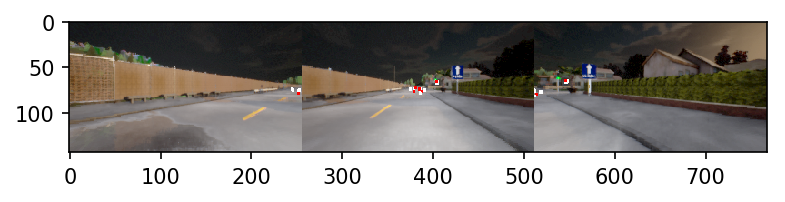

In [662]:
plt.imshow(img_3stack)
fig

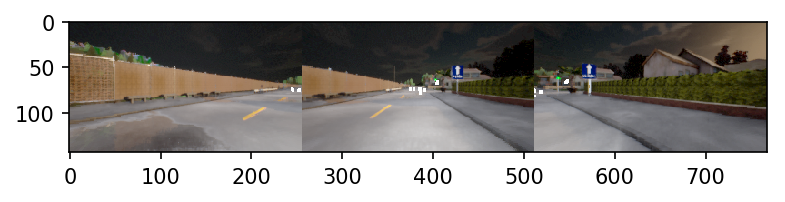

In [658]:
plt.imshow(img_3stack)
fig

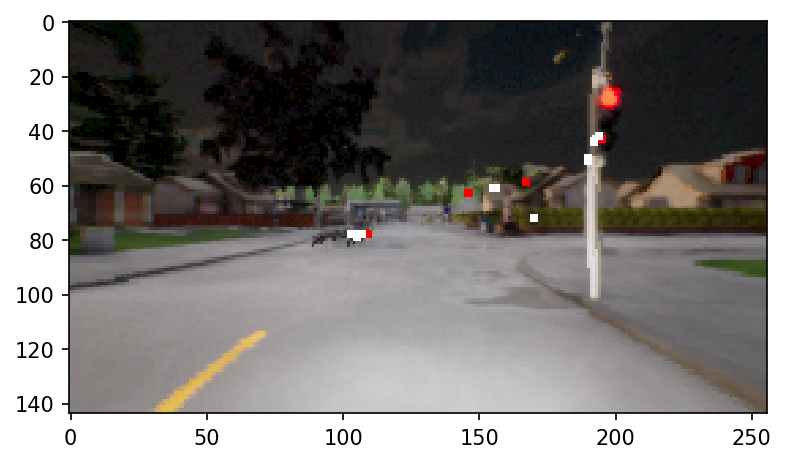

In [631]:
plt.imshow(rgb_img)
fig

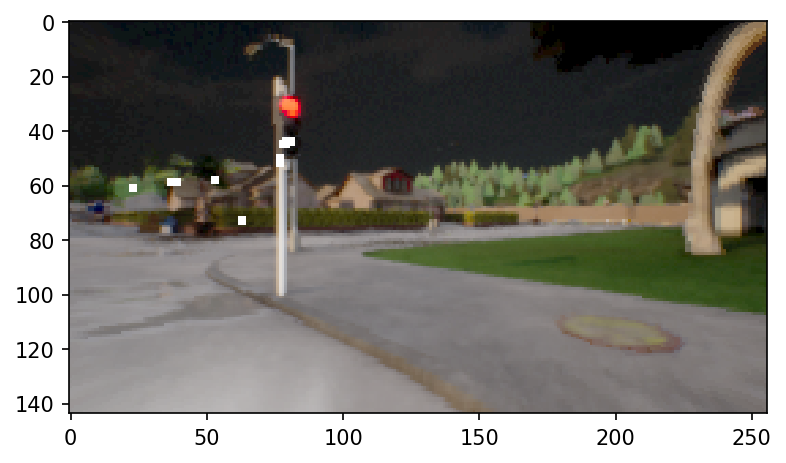

In [627]:
plt.imshow(right_img)
fig

In [669]:
df_new

,TimeElapsed,TimestampCarla,TimestampDevice,FrameSequence,GazeDir_COMBINED,GazeOrigin_COMBINED,GazeValid_COMBINED,GazeVergence_COMBINED,GazeDir_LEFT,GazeOrigin_LEFT,...,WorldPos,WorldRot,CombinedOrigin,gaze2target_pitch,gaze2target_yaw,head2target_pitch,head2target_yaw,LightOn,ButtonPressed,label
0,0.00000,2615,951967,101563729,"[0.998, 0.049, -0.044]","[-2.946, -0.018, 0.11]",1,297.3999,"[0.998, 0.053, -0.038]","[-2.821, 3.19, 0.325]",...,"[3397.174, 436.789, 121.553]","[6.482792, -16.570751, -1.488586]","[3394.376, 437.646, 121.312]",0.3982,0.5068,0.3220,0.4809,0,0,-1
1,0.40000,3792,956233,101564241,"[0.948, 0.061, -0.312]","[-3.001, -0.021, -0.094]",1,106.0495,"[0.953, 0.039, -0.301]","[-2.901, 3.171, 0.143]",...,"[3397.189, 436.932, 121.622]","[6.589049, -16.005905, -1.560242]","[3394.358, 437.723, 121.393]",0.3547,0.4372,0.3220,0.4809,0,0,0
2,0.80000,8046,956658,101564292,"[0.961, 0.19, -0.201]","[-3.004, -0.104, -0.058]",1,168.4239,"[0.964, 0.172, -0.202]","[-2.904, 3.095, 0.19]",...,"[3397.339, 439.618, 120.983]","[3.154038, -2.897553, -2.390625]","[3394.351, 439.752, 120.723]",0.6336,0.4667,0.3220,0.4809,0,0,0
3,1.20000,8482,956674,101564294,"[0.96, 0.19, -0.205]","[-3.003, -0.11, -0.053]",1,152.9364,"[0.964, 0.17, -0.203]","[-2.903, 3.088, 0.197]",...,"[-3396.83, 17673.428, 160.518]","[-20.223963, 161.1064, -3.481324]","[-3394.109, 17672.604, 161.497]",0.5102,0.2491,0.3220,0.4809,0,0,0
4,1.22884,8511,956708,101564298,"[0.963, 0.252, -0.091]","[-3.005, -0.137, 0.004]",1,528.8593,"[0.965, 0.247, -0.091]","[-2.908, 3.049, 0.253]",...,"[-3396.856, 17673.166, 145.431]","[-19.81286, 161.804703, -3.088715]","[-3394.12, 17672.379, 146.394]",0.5153,0.2521,0.3220,0.4809,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9459,211.30900,218590,1166787,101589513,"[0.997, -0.004, 0.075]","[-2.936, 0.005, 0.133]",1,41.4386,"[0.998, -0.004, 0.07]","[-2.772, 3.216, 0.337]",...,"[-5026.763, 13196.423, 119.533]","[-4.390193, 175.065704, -2.485843]","[-5023.856, 13196.173, 119.891]",0.1488,-0.0462,0.2278,-0.0546,0,0,0
9460,211.33000,218612,1166862,101589522,"[0.997, -0.002, 0.076]","[-2.938, 0.004, 0.133]",1,77.8265,"[0.998, -0.003, 0.069]","[-2.766, 3.215, 0.335]",...,"[-5026.768, 13196.439, 119.519]","[-4.404284, 175.003815, -2.395664]","[-5023.862, 13196.186, 119.877]",0.1488,-0.0465,0.2278,-0.0546,0,0,0
9461,211.40100,218683,1166879,101589524,"[0.997, -0.002, 0.076]","[-2.937, 0.003, 0.132]",1,156.2278,"[0.998, -0.004, 0.07]","[-2.763, 3.214, 0.333]",...,"[-5026.761, 13196.462, 119.525]","[-4.385794, 174.953949, -2.33414]","[-5023.853, 13196.207, 119.882]",0.1487,-0.0484,0.2278,-0.0546,0,0,0
9462,211.41500,218697,1166879,101589524,"[0.997, -0.0, 0.076]","[-2.937, 0.003, 0.132]",1,143.9705,"[0.998, -0.002, 0.07]","[-2.762, 3.214, 0.333]",...,"[-5026.74, 13196.516, 119.554]","[-4.342525, 175.067719, -2.397647]","[-5023.832, 13196.268, 119.908]",0.1495,-0.0485,0.2278,-0.0546,0,0,0


In [667]:
route_data_paths = list(Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/").glob("*/"))
route_data_paths.insert(0, Path('/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab11'))

for route_data_path in route_data_paths:
    # load the dreyevr data from recording txt
    participant_name_route = route_data_path.stem.split('_')[-1]
    participant_name = participant_name_route[:-2]
    recordingtxt_path = dreyevr_recording_txt_root / participant_name / (participant_name_route + ".txt")
    df_new = load_dreyevr_data_and_gazeevent_annotate(recordingtxt_path)

    dreyevr_data_path =  route_data_path / "dreyevr_data"

    # write a movie with gaze overlay
    movie_title = participant_name_route + ".mkv"
    if Path(movie_save_dir+movie_title).exists():
        continue
    
    resolution=200
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title=movie_title, artist='ajdroid', comment='dreyevrLBC-gaze-to-cam')
    writer = FFMpegWriter(fps=20, metadata=metadata)

    final_datapt_idx = int(sorted(list((route_data_path/'rgb').glob('*.png')))[-1].stem)
    datapt_idcs = np.arange(final_datapt_idx)+1 # starts from 0001.png
    prog = '' ; total_frames = datapt_idcs[-1]
    start = time.time()

    fig = plt.figure(dpi=resolution)
    gaze_memory_window=50 # this is number of ticks, x/20 is num seconds

    with writer.saving(fig, movie_save_dir+movie_title, resolution):
        for tick in range(1*10 + gaze_memory_window, (total_frames-3)*10):
            vehicle_transform = None
            tickbyten = tick//10
            tick_data = get_data(route_data_path, tickbyten)

            rgb_img = deepcopy(tick_data['rgb'])
            left_img = deepcopy(tick_data['rgb_left'])
            right_img = deepcopy(tick_data['rgb_right'])

            gaze_in_cam_arr = np.zeros((gaze_memory_window, 2))
            gaze_in_cam_arr_rgt = np.zeros((gaze_memory_window, 2))
            gaze_in_cam_arr_lft = np.zeros((gaze_memory_window, 2))

            for tick_mem in np.arange(tick, tick-gaze_memory_window, -1):
                dreyevr_data_t1 = dreyevr_data_path / ("{:04d}_{:05d}.pkl".format(tick_mem//10, tick_mem))
                with open(dreyevr_data_t1, 'rb') as f:
                    dreyevr_data_dict = pkl.load(f)

                tick_row_df = df_new[df_new.FrameSequence == dreyevr_data_dict['framesequence']]
                                
#                 if tick_mem==tick:
                    # if you want attention map in current location, use current vehicle loc 
                    # instead of vehicle loc at the time
                vehicle_loc = carla.Location(*(tick_row_df['VehicleLoc'].squeeze()))/100
                vehicle_rot = carla.Rotation(*(tick_row_df['VehicleRot'].squeeze()))    
                vehicle_transform = carla.Transform(location=vehicle_loc, rotation=vehicle_rot)

                # need to remove the saccades
                tick_focus_hitpt = np.array(tick_row_df.FocusInfo_HitPoint.squeeze())/100 # cm -> m

                gaze_in_cam_mid, gaze_in_cam_lft, gaze_in_cam_rgt  = world2pixels(tick_focus_hitpt, vehicle_transform, K)
                gaze_in_cam_arr[tick - tick_mem] = gaze_in_cam_mid
                gaze_in_cam_arr_rgt[tick - tick_mem] = gaze_in_cam_rgt
                gaze_in_cam_arr_lft[tick - tick_mem] = gaze_in_cam_lft

        #         print(tick_row_df["label"].squeeze())

                if tick_row_df["label"].squeeze() == 0:
                    dot(rgb_img, gaze_in_cam_mid[0], gaze_in_cam_mid[1], r=overlay_rad)
                    dot(right_img, gaze_in_cam_rgt[0], gaze_in_cam_rgt[1], r=overlay_rad)
                    dot(left_img, gaze_in_cam_lft[0], gaze_in_cam_lft[1], r=overlay_rad)
                elif tick_row_df["label"].squeeze() == 1:
                    color = (255, 0, 0)
                    dot(rgb_img, gaze_in_cam_mid[0], gaze_in_cam_mid[1], color=color, r=overlay_rad)
                    dot(right_img, gaze_in_cam_rgt[0], gaze_in_cam_rgt[1], color=color, r=overlay_rad)
                    dot(left_img, gaze_in_cam_lft[0], gaze_in_cam_lft[1], color=color, r=overlay_rad)

            img_3stack = np.hstack([left_img, rgb_img, right_img])
            
            plt.imshow(img_3stack)

            writer.grab_frame() ; fig.clear()
            tstr = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))
            print('\ttime: {} | progress: {:.1f}%'.format(tstr, 100*tickbyten/total_frames), end='\r')
#     break

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.104s
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/brady32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.093s
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/dexter32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.036s
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.100s
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/dexter11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.088s
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab54.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.089s
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/brady11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.099s
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_p

ArgumentError: Python argument types in
    Location.__init__(Location, list, list)
did not match C++ signature:
    __init__(_object*, carla::geom::Vector3D rhs)
    __init__(_object*, float x=0.0, float y=0.0, float z=0.0)
    __init__(_object*)

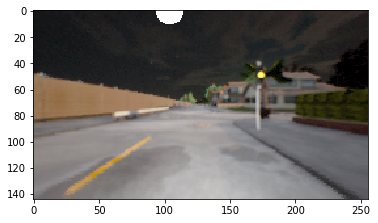

In [400]:
debug_fig = plt.figure()
rgb_img = deepcopy(tick_data['rgb'])
tick_row_df = df_new[df_new.FrameSequence == dreyevr_data_dict['framesequence']]
# do math instead of using hitpt
dot(rgb_img, int(gaze_in_cam[0]), int(gaze_in_cam[1]))
plt.imshow(rgb_img)
debug_fig.show()

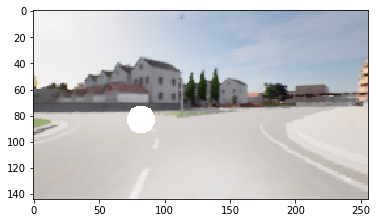

In [238]:
debug_fig = plt.figure()
rgb_img = deepcopy(tick_data['rgb'])
dot(rgb_img, int(gaze_in_cam[0]), int(gaze_in_cam[1]))
plt.imshow(rgb_img)
debug_fig.show()

In [ ]:
TraceLen = MaxTraceLenM * 100.; # convert to m from cm

# WorldRot = GetData()->GetCameraRotationAbs();
# WorldPos = GetData()->GetCameraLocationAbs();
# GazeOrigin = WorldPos + WorldRot.RotateVector(GetData()->GetGazeOrigin());
# GazeRay = TraceLen * WorldRot.RotateVector(GetData()->GetGazeDir());
# GazeOrigin + GazeRay

gaze_orig = dreyevr_data_dict['gaze_origin']
gaze_dir = dreyevr_data_dict['gaze_dir']
camera_rot = dreyevr_data_dict['camera_rotation']
R.from_euler('xyz', camera_rot)
gaze_posn_rel = camera_rot.apply(gaze_dir)